In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install captum  #pyhton library , to analyse how does a model predict a class 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.1 MB/s eta 0:00:0000:0100:01
  Attempting uninst

In [5]:
import os
import torch
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "./results"
os.makedirs(save_dir, exist_ok=True)


# Load pretrained-models

In [6]:
#  Load trained model

from torchvision import models
import torch.nn as nn

num_classes = 10
save_dir = "./results"
model_names = ["resnet18", "xception65", "densenet121"]

import timm
from torch import nn

def get_model(name, num_classes=10, pretrained=True, device=None):
    if name == "resnet18":
        from torchvision import models
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        model = models.resnet18(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "densenet121":
        from torchvision import models
        weights = models.DenseNet121_Weights.DEFAULT if pretrained else None
        model = models.densenet121(weights=weights)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif name == "xception65" :
        model = timm.create_model("xception", pretrained=pretrained, num_classes=num_classes)

    else:
        raise ValueError(f"Unsupported model name: {name}")

    if device:
        model = model.to(device)
    return model

model_names = ["resnet18", "xception65", "densenet121"]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# preprocessing

In [7]:

test_transform = transforms.Compose([
    transforms.Resize((224,224)),  # pretrained models expect 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616)) #MEAN AND STD FOR RGB 
])

test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) #load 1 image at a time 
classes = test_dataset.classes

100%|██████████| 170M/170M [00:02<00:00, 68.2MB/s] 


# Denormalization, Heatmap Resizing, and Overlay

In [8]:
# 3. Helper functions

def denormalize(img_tensor):

    if isinstance(img_tensor, torch.Tensor):
        img = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    else:
        img = np.array(img_tensor).transpose(1,2,0)
    img = img * np.array([0.2470,0.2435,0.2616]) + np.array([0.4914,0.4822,0.4465])
    img = np.clip(img, 0, 1)
    return img

def _resize_heatmap_np(heatmap_np, target_h, target_w):

    h, w = heatmap_np.shape
    if (h, w) == (target_h, target_w):
        return heatmap_np
    t = torch.from_numpy(heatmap_np.astype(np.float32)).unsqueeze(0).unsqueeze(0)  # 1x1xH xW
    t_up = F.interpolate(t, size=(target_h, target_w), mode='bilinear', align_corners=False)
    out = t_up.squeeze().cpu().numpy()
    return out

def overlay_heatmap_on_image(ax, image_np, heatmap_2d, cmap='jet', alpha=0.5, title=""):

    ax.imshow(image_np)
    ax.imshow(heatmap_2d, cmap=cmap, alpha=alpha, vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

# Grad-CAM, Integrated Gradients, and Eigen-CAM Implementations

In [9]:
#  Explainability functions
def grad_cam(model, layer, input_tensor, target_class):

    model.eval()
    cam = LayerGradCam(model, layer)
    # attribution: same device, shape 1 x channels x h x w
    attribution = cam.attribute(input_tensor, target=target_class)
    # Upsample to input spatial dims using LayerAttribution.interpolate (returns tensor)
    upsampled_attr = LayerAttribution.interpolate(attribution, (input_tensor.shape[2], input_tensor.shape[3]))
    heatmap = upsampled_attr.squeeze().cpu().detach().numpy()
    # If the layer has multiple channels, sum across them to get 2D (some cam implementations return single channel)
    if heatmap.ndim == 3:
        heatmap = np.sum(np.abs(heatmap), axis=0)
    # normalize
    heatmap = heatmap - heatmap.min()
    denom = heatmap.max() + 1e-8
    heatmap = heatmap / denom
    return heatmap

def integrated_gradients(model, input_tensor, target_class, n_steps=50):

    model.eval()
    ig = IntegratedGradients(model)
    attributions = ig.attribute(input_tensor, target=target_class, n_steps=n_steps)
    # attributions: 1 x C x h x w
    attr_np = attributions.squeeze().cpu().detach().numpy()
    # sum absolute across channels -> 2D
    heatmap = np.sum(np.abs(attr_np), axis=0)
    heatmap = heatmap - heatmap.min()
    denom = heatmap.max() + 1e-8
    heatmap = heatmap / denom
    return heatmap

def eigen_cam(model, layer, input_tensor, target_class):

    return grad_cam(model, layer, input_tensor, target_class)

Code to pick each model , test on data , varify whether is it correct or incorrect prediction and store it in array


In [10]:
def get_sample_images(model, test_loader, num_samples=5):
    correct_imgs, correct_labels, preds_correct = [], [], []
    misclass_imgs, misclass_labels, preds_misclass = [], [], []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)

            if pred == labels and len(correct_imgs) < num_samples:
                correct_imgs.append(images.clone().detach())
                correct_labels.append(labels.clone().detach())
                preds_correct.append(pred.clone().detach())
            elif pred != labels and len(misclass_imgs) < num_samples:
                misclass_imgs.append(images.clone().detach())
                misclass_labels.append(labels.clone().detach())
                preds_misclass.append(pred.clone().detach())

            if len(correct_imgs) >= num_samples and len(misclass_imgs) >= num_samples:
                break

    return (correct_imgs, correct_labels, preds_correct), (misclass_imgs, misclass_labels, preds_misclass)


Explainability for resnet18 


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s] 


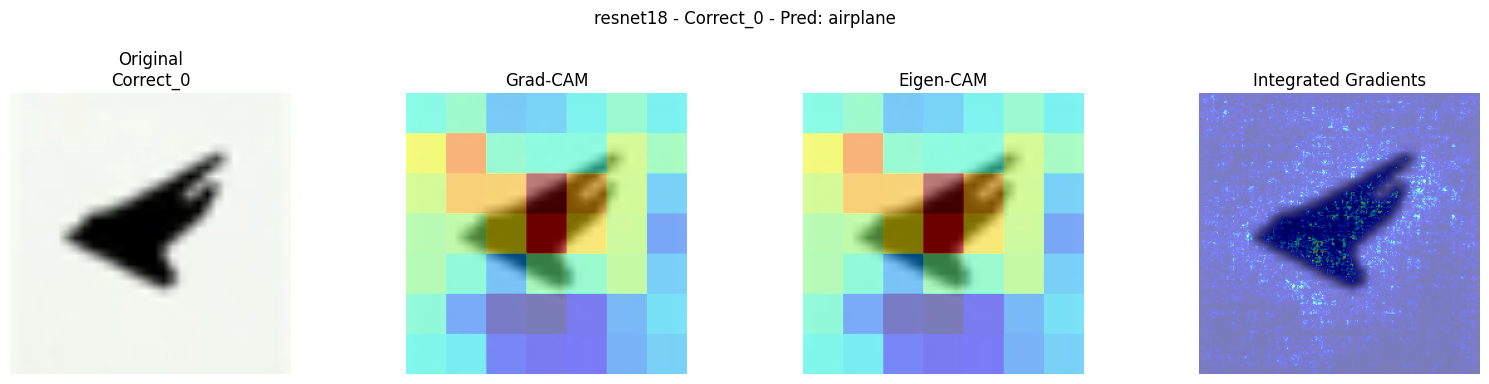

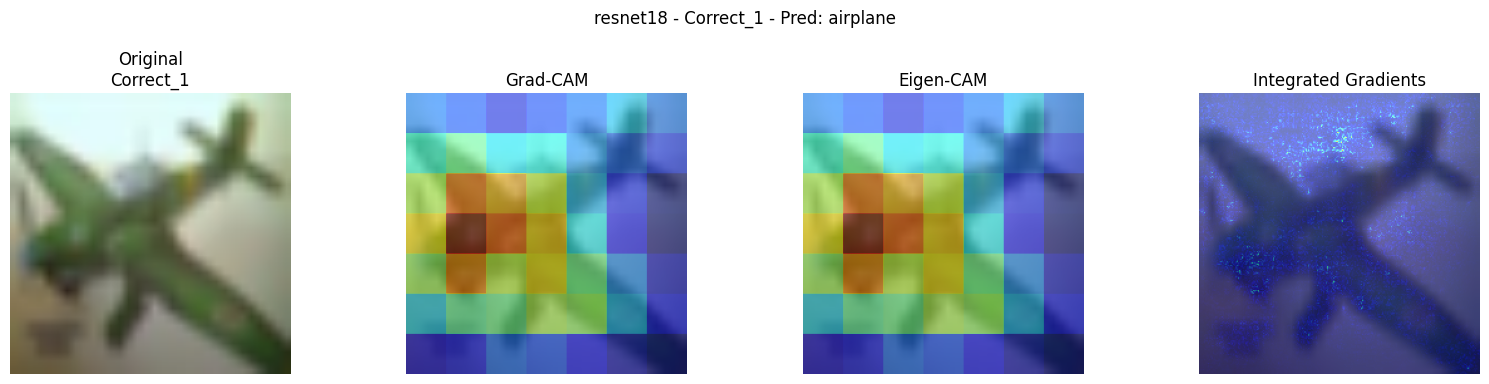

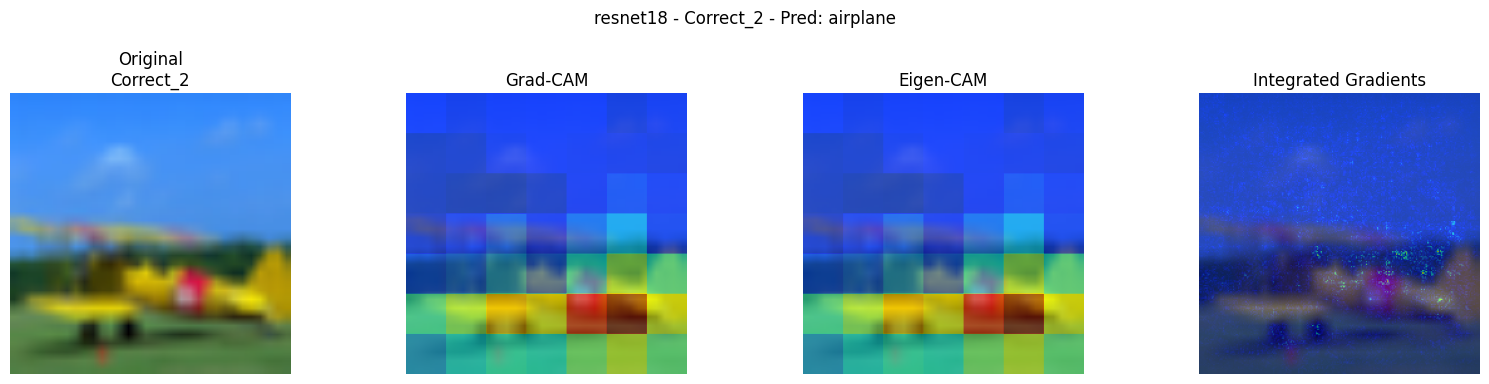

Misclassified Predictions (raw images):


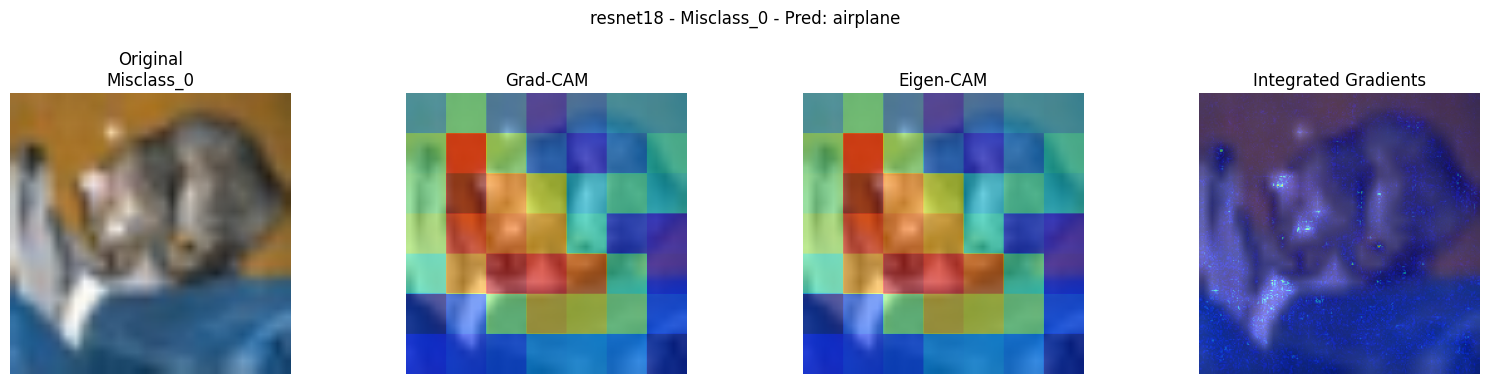

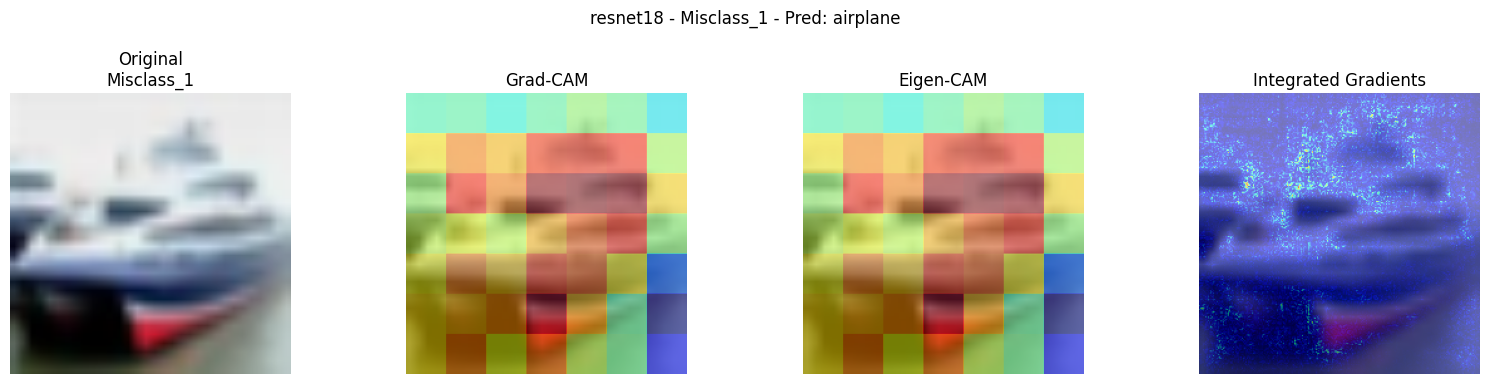

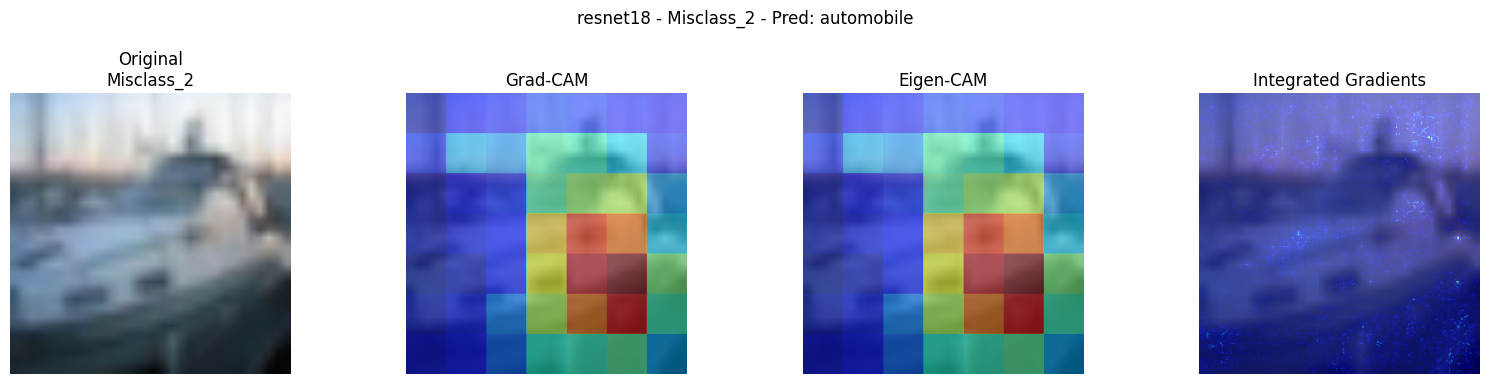


Explainability for xception65 


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


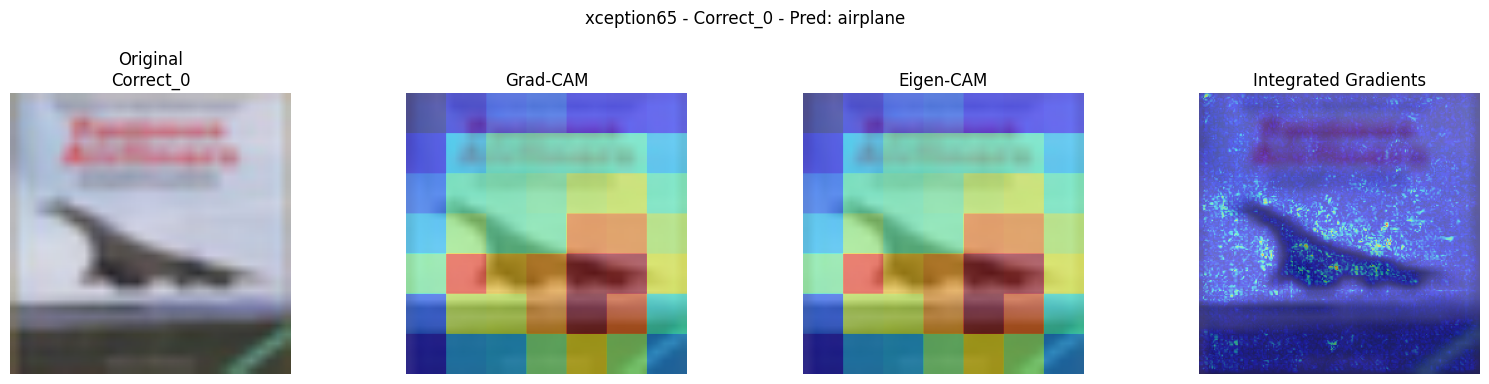

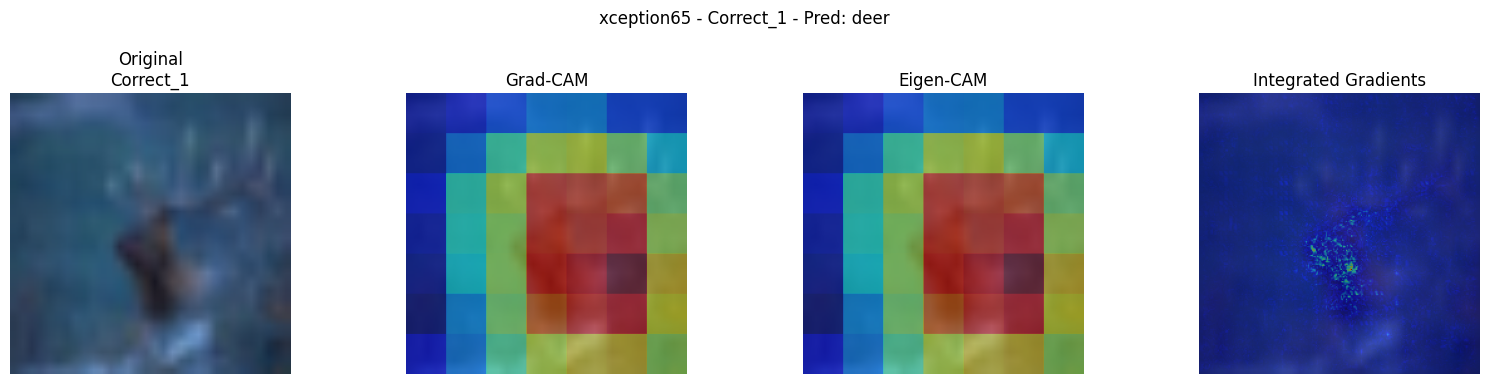

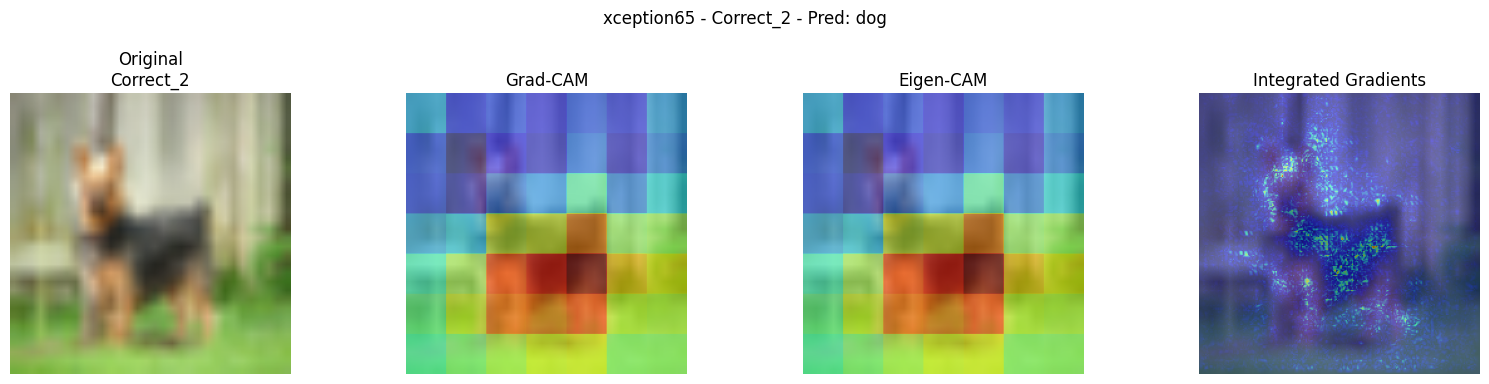

Misclassified Predictions (raw images):


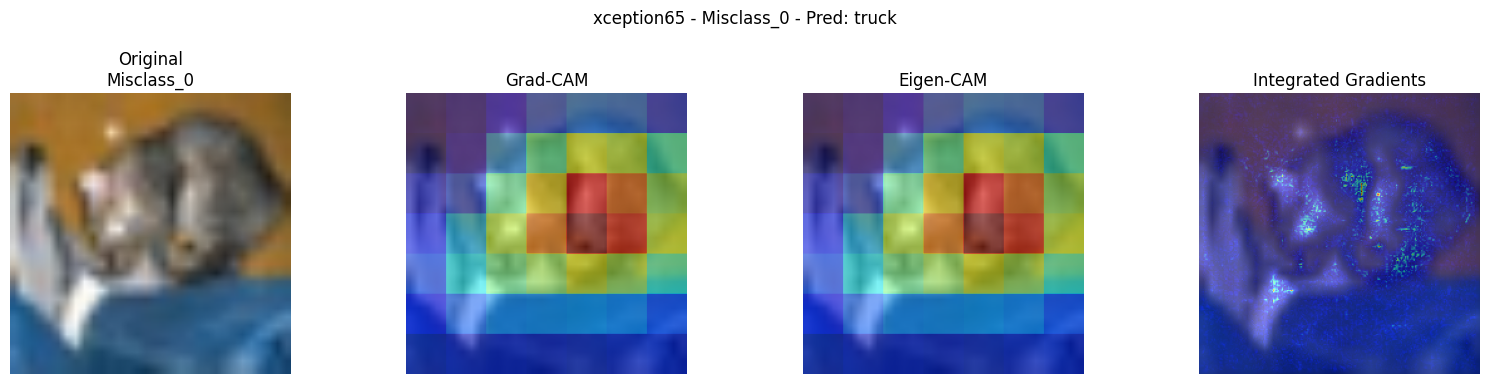

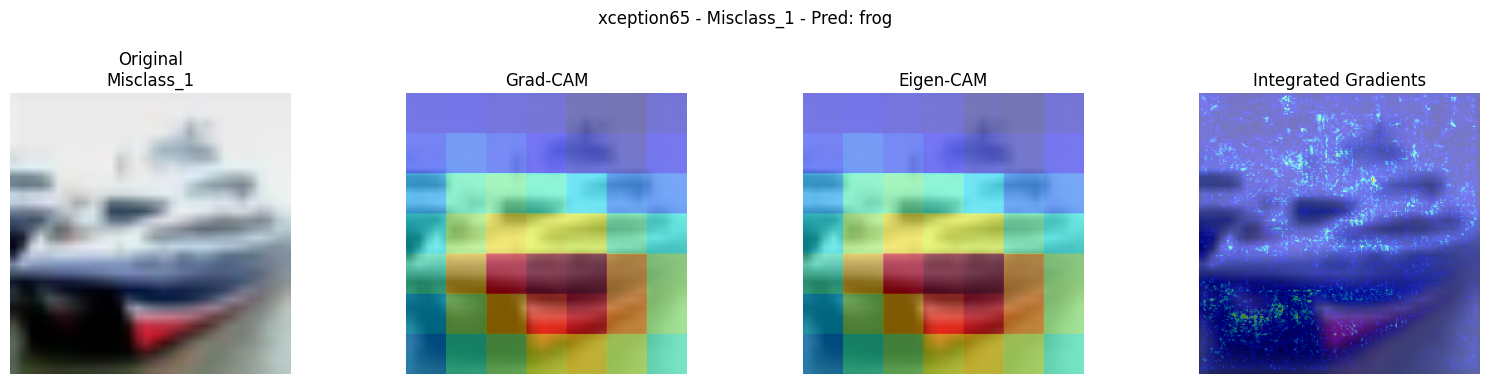

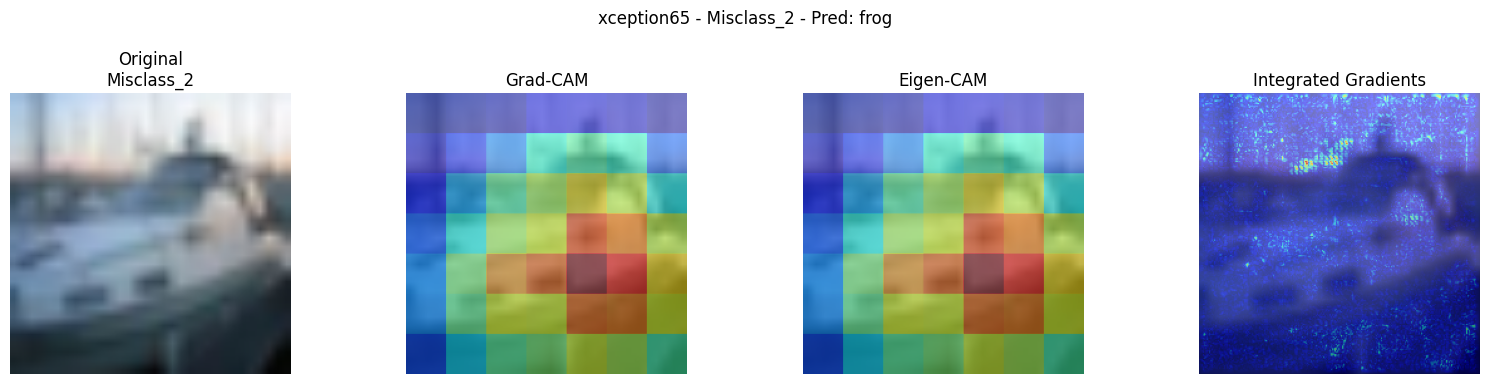

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Explainability for densenet121 


100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s] 


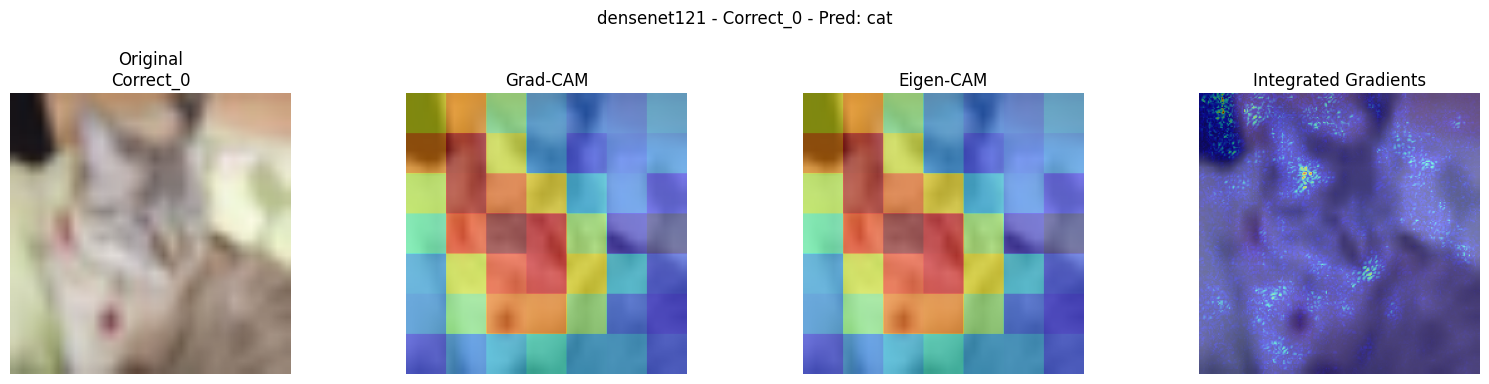

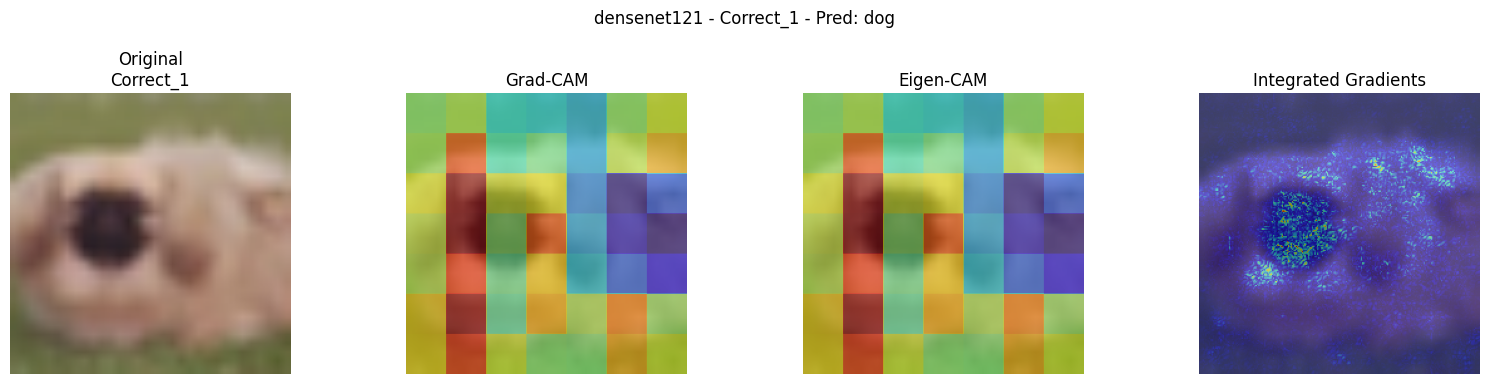

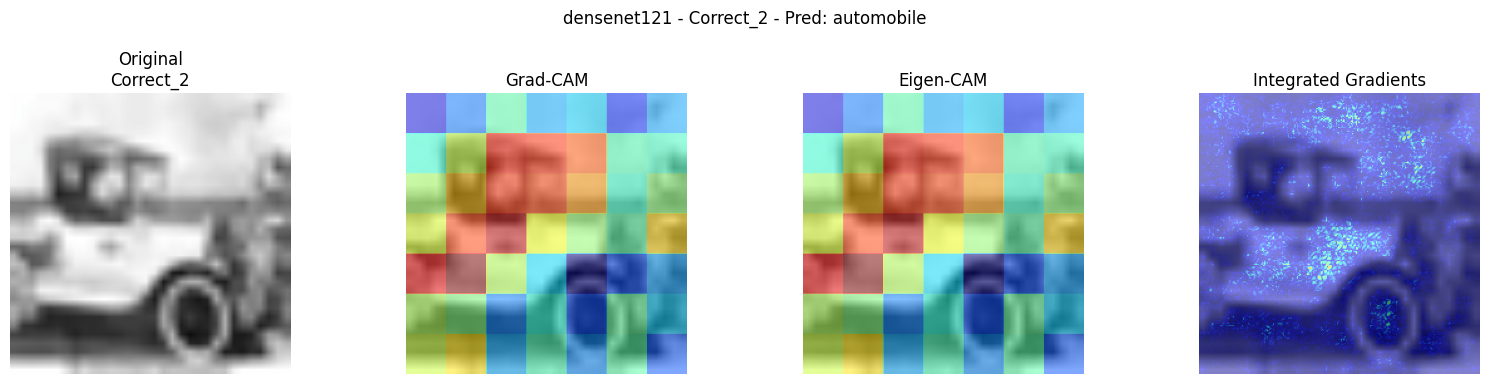

Misclassified Predictions (raw images):


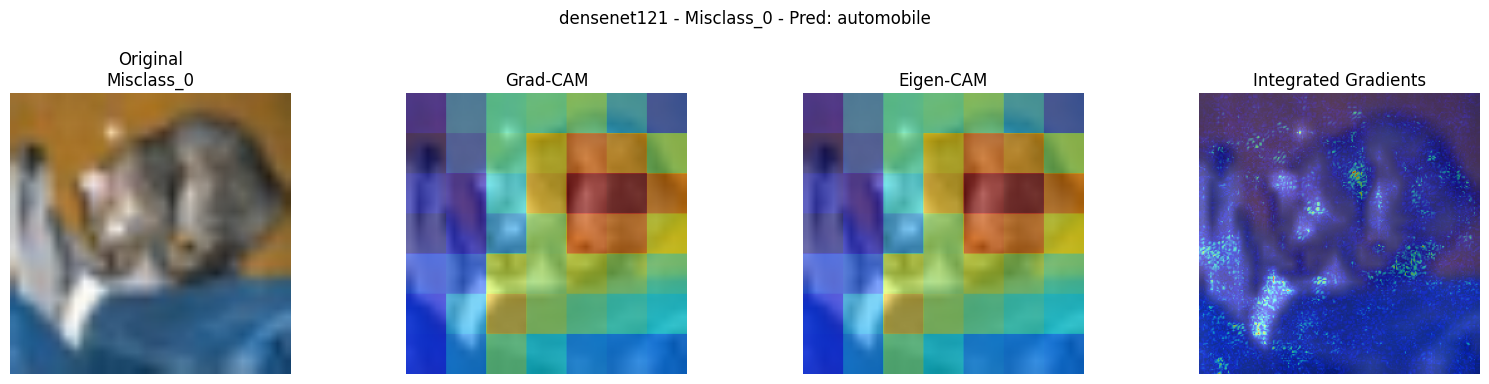

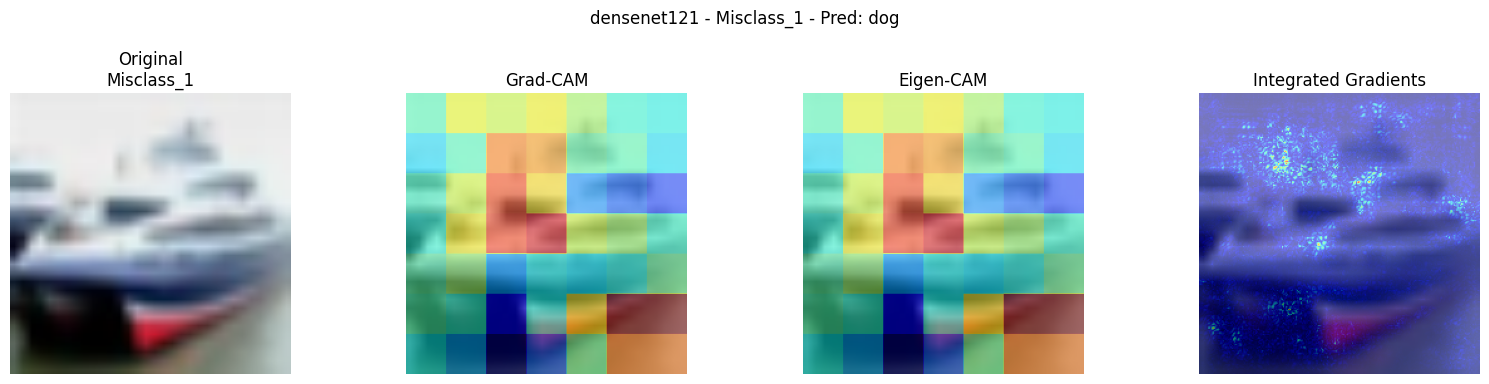

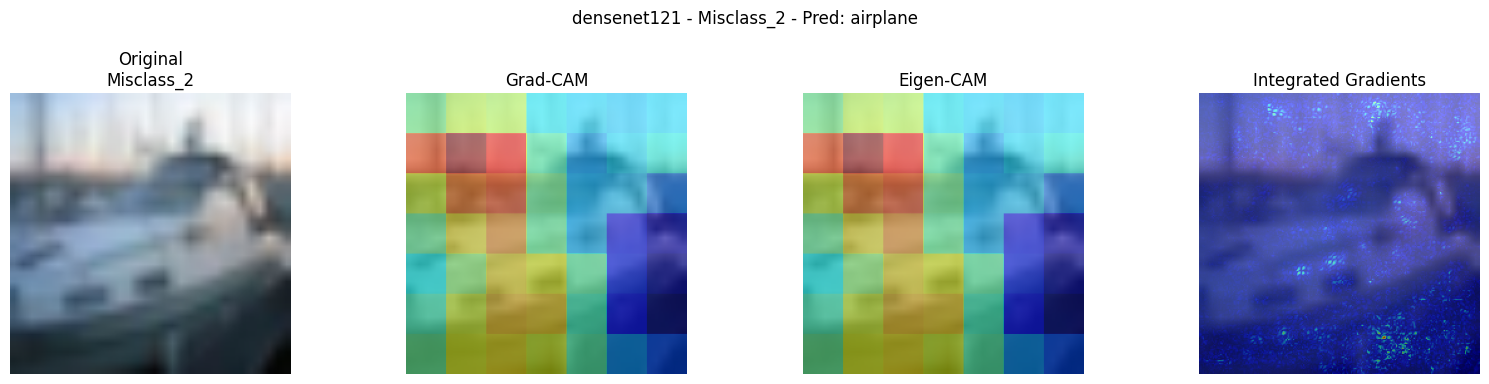

In [11]:

#  Visualize images & explanations (each image: original, gradcam, eigencam, ig)

def visualize_for_model(name, save=False, max_per_type=5):
    print(f"\nExplainability for {name} ")


    model = get_model(name, device=device)
    model.eval()

    # pick a typical last conv layer for CAMs
    if name == "resnet18":
        layer = model.layer4[-1]          
    elif name == "densenet121":
        layer = model.features[-1]       
    elif name == "xception65":
        layer = model.conv4
    else:
        raise ValueError("Unsupported model for layer selection")




    (correct_imgs, correct_labels, preds_correct), (misclass_imgs, misclass_labels, preds_misclass) = get_sample_images(model, test_loader, num_samples=max_per_type)

    def _process_and_plot(img_tensor, predicted_label, tag):
        input_tensor = img_tensor.to(device)
        target_class = int(predicted_label)
        img_cpu = denormalize(img_tensor.squeeze().cpu())
        gc = grad_cam(model, layer, input_tensor, target_class)           
        ig = integrated_gradients(model, input_tensor, target_class)    
        eig = eigen_cam(model, layer, input_tensor, target_class)        
        H, W = img_cpu.shape[0], img_cpu.shape[1]
        gc_r = _resize_heatmap_np(gc, H, W)
        ig_r = _resize_heatmap_np(ig, H, W)
        eig_r = _resize_heatmap_np(eig, H, W)
        def norm01(x):
            x = x - x.min()
            denom = x.max() + 1e-8
            return x / denom

        gc_r = norm01(gc_r)
        ig_r = norm01(ig_r)
        eig_r = norm01(eig_r)

        # plot: 1x4 grid (Original | Grad-CAM | Eigen-CAM | Integrated Gradients)
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        axes[0].imshow(img_cpu)
        axes[0].set_title(f"Original\n{tag}")
        axes[0].axis('off')

        overlay_heatmap_on_image(axes[1], img_cpu, gc_r, title="Grad-CAM")
        overlay_heatmap_on_image(axes[2], img_cpu, eig_r, title="Eigen-CAM")
        overlay_heatmap_on_image(axes[3], img_cpu, ig_r, title="Integrated Gradients")

        plt.suptitle(f"{name} - {tag} - Pred: {classes[target_class]}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        if save:
            filename = f"{save_dir}/{name}_{tag.replace(' ','_')}_{classes[target_class]}.png"
            plt.savefig(filename, bbox_inches='tight', dpi=150)
            print(f"Saved to {filename}")

        plt.show()
        plt.close(fig)

  
    for i in range(len(correct_imgs)):
        _process_and_plot(correct_imgs[i], preds_correct[i], tag=f"Correct_{i}")

   
    print("Misclassified Predictions (raw images):")
    for i in range(len(misclass_imgs)):
        _process_and_plot(misclass_imgs[i], preds_misclass[i], tag=f"Misclass_{i}")

# Run for each model
for mname in model_names:
    visualize_for_model(mname, save=False, max_per_type=3)